# 取得數據和產生買賣序列all in one

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_binance_kline(symbol: str, interval: str, end_time: datetime, limit: int = 300) -> pd.DataFrame:
    base_url = "https://api.binance.com/api/v3/klines"
    end_timestamp = int(end_time.timestamp() * 1000)
    params = {
        "symbol": symbol.upper(),
        "interval": interval,
        "endTime": end_timestamp,
        "limit": limit
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    data = response.json()

    df = pd.DataFrame(data, columns=[
        "timestamp", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignore"
    ])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df["close"] = df["close"].astype(float)
    return df[["timestamp", "close"]]

def detect_sma_cross(df: pd.DataFrame) -> pd.DataFrame:
    df["sma5"] = df["close"].rolling(window=1).mean()
    df["sma10"] = df["close"].rolling(window=2).mean()

    # 判斷黃金交叉與死亡交叉
    df["signal"] = 0
    cross_up = (df["sma5"] > df["sma10"]) & (df["sma5"].shift(1) <= df["sma10"].shift(1))
    cross_down = (df["sma5"] < df["sma10"]) & (df["sma5"].shift(1) >= df["sma10"].shift(1))
    df.loc[cross_up, "signal"] = 1   # 黃金交叉
    df.loc[cross_down, "signal"] = -1  # 死亡交叉

    return df

def get_sma_signals(symbol: str, interval: str, end_time: datetime) -> pd.DataFrame:
    df = get_binance_kline(symbol, interval, end_time)
    df = detect_sma_cross(df)
    return df


In [2]:
from datetime import datetime

# 抓 BTCUSDT 的 1小時線，以現在時間為終點
df_signals = get_sma_signals("BTCUSDT", "1h", datetime.now())

print(df_signals.tail(10)[["timestamp", "close", "sma5", "sma10", "signal"]])
print(df_signals['signal'].value_counts())

              timestamp      close       sma5       sma10  signal
290 2025-07-25 22:00:00  117279.97  117279.97  117247.100       0
291 2025-07-25 23:00:00  117614.31  117614.31  117447.140       0
292 2025-07-26 00:00:00  117496.00  117496.00  117555.155      -1
293 2025-07-26 01:00:00  117153.73  117153.73  117324.865       0
294 2025-07-26 02:00:00  117469.00  117469.00  117311.365       1
295 2025-07-26 03:00:00  117489.62  117489.62  117479.310       0
296 2025-07-26 04:00:00  117496.81  117496.81  117493.215       0
297 2025-07-26 05:00:00  117444.99  117444.99  117470.900      -1
298 2025-07-26 06:00:00  117350.71  117350.71  117397.850       0
299 2025-07-26 07:00:00  117329.56  117329.56  117340.135       0
signal
 0    156
 1     72
-1     72
Name: count, dtype: int64


# 回測

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_signals(df: pd.DataFrame,
                     initial_capital=100_000,
                     fee_rate=0.001,
                     leverage=1,
                     allow_short=True,
                     risk_free_rate=0.0,
                     plot=False):
    
    df = df.copy().reset_index(drop=True)
    df["position"] = 0

    # === 建立部位 ===
    for i in range(1, len(df)):
        signal = df.loc[i, "signal"]
        prev_pos = df.loc[i - 1, "position"]
        if signal == 1:
            df.loc[i, "position"] = leverage  # 做多 + 槓桿
        elif signal == -1 and allow_short:
            df.loc[i, "position"] = -leverage  # 做空
        elif signal == -1 and not allow_short:
            df.loc[i, "position"] = 0  # 出場
        else:
            df.loc[i, "position"] = prev_pos  # 持續持倉

    # === 報酬計算 ===
    df["return"] = df["close"].pct_change()
    df["strategy_return"] = df["return"] * df["position"].shift(1).fillna(0)

    # === 手續費 ===
    df["trade"] = df["position"] != df["position"].shift(1)
    df["strategy_return_with_fee"] = df["strategy_return"]
    df.loc[df["trade"], "strategy_return_with_fee"] -= fee_rate * abs(df["position"])

    # === 資產曲線 ===
    df["equity"] = initial_capital * (1 + df["strategy_return_with_fee"]).cumprod()
    df["buy_and_hold"] = initial_capital * (1 + df["return"].fillna(0)).cumprod()

    # === 最大回撤 ===
    df["peak"] = df["equity"].cummax()
    df["drawdown"] = df["equity"] / df["peak"] - 1
    max_drawdown = df["drawdown"].min()

    # === Sharpe Ratio ===
    daily_return = df["strategy_return_with_fee"].mean()
    daily_std = df["strategy_return_with_fee"].std()
    sharpe_ratio = (daily_return - risk_free_rate) / daily_std * np.sqrt(252) if daily_std > 0 else 0

    # === 報酬統計 ===
    total_return = df["equity"].iloc[-1] / initial_capital - 1
    days = (df["timestamp"].iloc[-1] - df["timestamp"].iloc[0]).days
    annual_return = (1 + total_return) ** (365 / days) - 1 if days > 0 else 0

    # === 單筆交易統計 ===
    trade_returns = []
    hold_days = []
    entry_price = None
    entry_time = None
    entry_position = 0

    for i in range(len(df)):
        row = df.iloc[i]
        if row["trade"]:
            if entry_price is not None and entry_position != 0:
                exit_price = row["close"] * (1 - fee_rate)
                if entry_position > 0:
                    rtn = (exit_price / entry_price) - 1
                else:
                    rtn = (entry_price / exit_price) - 1
                rtn *= leverage
                days_held = (row["timestamp"] - entry_time).days
                trade_returns.append(rtn)
                hold_days.append(days_held)

            # 新進場
            entry_price = row["close"] * (1 + fee_rate)
            entry_time = row["timestamp"]
            entry_position = row["position"]

    num_trades = len(trade_returns)
    win_rate = np.mean([1 if r > 0 else 0 for r in trade_returns]) if num_trades > 0 else 0
    avg_profit = np.mean(trade_returns) if num_trades > 0 else 0
    avg_days = np.mean(hold_days) if hold_days else 0

    # === 畫圖 ===
    if plot:
        fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [2, 1]})
        
        # 資產曲線
        axs[0].plot(df["timestamp"], df["equity"], label="Strategy")
        axs[0].plot(df["timestamp"], df["buy_and_hold"], label="Buy and Hold", linestyle="--", alpha=0.6)
        axs[0].set_title("Equity Curve")
        axs[0].legend()
        axs[0].grid()

        # 交易報酬分布圖
        axs[1].hist(np.array(trade_returns) * 100, bins=20, color="skyblue", edgecolor="k")
        axs[1].set_title("Trade Return Distribution (%)")
        axs[1].grid()

        plt.tight_layout()
        plt.show()

    return {
        "總報酬率": round(total_return * 100, 2),
        "年化報酬率": round(annual_return * 100, 2),
        "最大回撤": round(max_drawdown * 100, 2),
        "Sharpe Ratio": round(sharpe_ratio, 2),
        "交易次數": num_trades,
        "勝率": round(win_rate * 100, 2),
        "平均持有天數": round(avg_days, 2),
        "平均每筆報酬率": round(avg_profit * 100, 2),
        "timestamp":df["timestamp"].values,
        "equity":df["equity"].values,
        "buy_and_hold":df["buy_and_hold"].values.tolist(),
        "trade_returns":np.array(trade_returns) * 100,
    }
result = backtest_signals(df_signals)

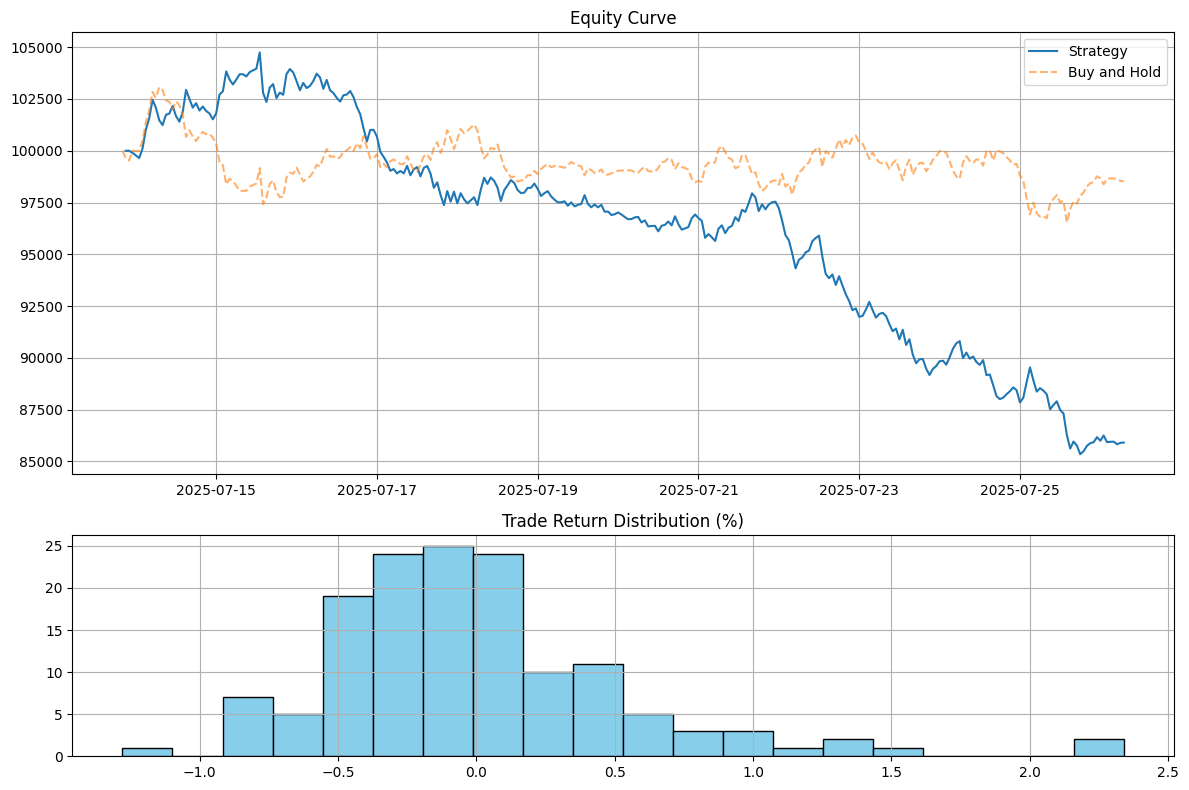

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [2, 1]})
        
# 資產曲線
axs[0].plot(result["timestamp"], result["equity"], label="Strategy")
axs[0].plot(result["timestamp"], result["buy_and_hold"], label="Buy and Hold", linestyle="--", alpha=0.6)
axs[0].set_title("Equity Curve")
axs[0].legend()
axs[0].grid()

# 交易報酬分布圖
axs[1].hist(np.array(result['trade_returns']) , bins=20, color="skyblue", edgecolor="k")
axs[1].set_title("Trade Return Distribution (%)")
axs[1].grid()

plt.tight_layout()
plt.show()

# 實際上線下單

In [ ]:
import ccxt
import time

# ✅ 幣安 API 下單模組 (現貨)
def create_binance_client():
    import ccxt
    api_key = 'mWLGc0yuQVCj6LPmTiem9moqSpDM9vLi2KFVSqaoQJppQVBqEopGs0YihGUDqKxN'
    secret = 'fub6Hre7UAzEkEjF3sdV5Pa1BE85xM7ptFeNysMTOvq28ZkQXfDfDEyv2ptVqG9I'
    client = ccxt.binance({
        'apiKey': api_key,
        'secret': secret,
        'enableRateLimit': True,
        'options': {'defaultType': 'spot'}
    })
    client.set_sandbox_mode(True)  # 關鍵！！
    return client

# ✅ 自動交易機制
def auto_trade_sma(symbol="ETH/USDT", interval="1m", usdt_per_order=50):
    client = create_binance_client()
    last_position = 0  # -1: 空單, 0: 無單, 1: 多單

    # 根據幣安 interval 轉秒數
    interval_sec = {
        "1m": 60, "3m": 180, "5m": 300, "15m": 900, "30m": 1800,
        "1h": 3600, "2h": 7200, "4h": 14400, "1d": 86400
    }[interval]

    while True:
        try:
            now = datetime.utcnow()
            df = get_sma_signals(symbol.replace("/", ""), interval, now)
            latest = df.iloc[-1]

            print(f"[{now.strftime('%Y-%m-%d %H:%M:%S')}] Close: {latest['close']:.2f}, Signal: {latest['signal']}")

            # 只有在訊號發生時才處理
            if latest["signal"] == 1 and last_position <= 0:
                print("🟢 黃金交叉 → 買入")
                client.create_market_buy_order(symbol, amount=usdt_per_order / latest["close"])
                last_position = 1
            elif latest["signal"] == -1 and last_position >= 0:
                print("🔴 死亡交叉 → 賣出")
                balance = client.fetch_balance()
                coin = symbol.split("/")[0]
                amount = balance[coin]["free"]
                if amount > 0.0001:
                    client.create_market_sell_order(symbol, amount=amount)
                last_position = -1
            else:
                print("⏸ 無操作")
            
            # 看一下eth餘額usdt餘額
            balance = client.fetch_balance()
            print(f"ETH 餘額：{balance['total'].get('ETH', 0)}")
            print(f"USDT 餘額：{balance['total'].get('USDT', 0)}")
    
        except Exception as e:
            print(f"❌ 發生錯誤：{e}")

        # 等待下一輪
        time.sleep(interval_sec)

auto_trade_sma()

'\nimport ccxt\nfrom getpass import getpass  # 用於安全輸入 API Key\nimport time\n\n# ✅ 幣安 API 下單模組 (現貨)\ndef create_binance_client():\n    import ccxt\n    api_key = \'mWLGc0yuQVCj6LPmTiem9moqSpDM9vLi2KFVSqaoQJppQVBqEopGs0YihGUDqKxN\'\n    secret = \'fub6Hre7UAzEkEjF3sdV5Pa1BE85xM7ptFeNysMTOvq28ZkQXfDfDEyv2ptVqG9I\'\n    client = ccxt.binance({\n        \'apiKey\': api_key,\n        \'secret\': secret,\n        \'enableRateLimit\': True,\n        \'options\': {\'defaultType\': \'spot\'}\n    })\n    client.set_sandbox_mode(True)  # 關鍵！！\n    return client\n\n# ✅ 自動交易機制\ndef auto_trade_sma(symbol="ETH/USDT", interval="1m", usdt_per_order=50):\n    client = create_binance_client()\n    last_position = 0  # -1: 空單, 0: 無單, 1: 多單\n\n    # 根據幣安 interval 轉秒數\n    interval_sec = {\n        "1m": 60, "3m": 180, "5m": 300, "15m": 900, "30m": 1800,\n        "1h": 3600, "2h": 7200, "4h": 14400, "1d": 86400\n    }[interval]\n\n    while True:\n        try:\n            now = datetime.utcnow()\n         

In [6]:
import ccxt
from datetime import datetime
import time
import pandas as pd  # 假設 get_sma_signals 回傳 DataFrame

# 初始化 Binance USDT 永續合約客戶端
def create_binance_futures_client():
    api_key = '074bfe01cf7533fff407a680cdd32df3cd912378a9cbcd55787b2d136140ae48'
    secret = '3747cfeb3b75c7790a1f9c2d29eb11d45dd5b0626086dfb3cc2895d2051fc9db'
    client = ccxt.binance({
        'apiKey': api_key,
        'secret': secret,
        'enableRateLimit': True,
        'options': {
            'defaultType': 'future',  # 永續合約
        }
    })
    client.set_sandbox_mode(True)  # 測試用沙盒
    return client

# 設定槓桿 (數字，ex: 5)
def set_leverage(client, symbol, leverage=5):
    try:
        client.set_leverage(leverage, symbol)
        print(f"✅ 槓桿設為 {leverage}x")
    except Exception as e:
        print(f"設定槓桿失敗: {e}")

# 取得持倉資訊
def get_position(client, symbol):
    try:
        positions = client.fetch_positions([symbol])
        for pos in positions:
            if pos['symbol'] == symbol:
                return float(pos['contracts'])  # 多為正，空為負
    except Exception as e:
        print(f"查持倉錯誤: {e}")
    return 0

# 取得可用餘額（USDT）
def get_usdt_balance(client):
    try:
        balance = client.fetch_balance()
        return balance['USDT']['free']
    except Exception as e:
        print(f"查餘額錯誤: {e}")
        return 0

def get_min_order_amount(client, symbol):
    try:
        markets = client.load_markets()
        min_amt = markets[symbol]['limits']['amount']['min']
        print(f"✅ {symbol} 的最小下單量為 {min_amt}")
        return float(min_amt)
    except Exception as e:
        print(f"❌ 無法取得最小下單量: {e}")
        return 0.01  # 預設保底

def auto_trade_sma_futures(symbol="ETH/USDT", interval="1m", usdt_per_order=50, leverage=5):
    client = create_binance_futures_client()
    set_leverage(client, symbol, leverage)
    min_amount = get_min_order_amount(client, symbol)  # 新增：抓最小下單量

    interval_sec = {
        "1m": 60, "3m": 180, "5m": 300, "15m": 900, "30m": 1800,
        "1h": 3600, "2h": 7200, "4h": 14400, "1d": 86400
    }[interval]

    while True:
        try:
            now = datetime.utcnow()
            df = get_sma_signals(symbol.replace("/", ""), interval, now)
            latest = df.iloc[-1]
            close_price = latest['close']
            signal = latest['signal']

            print(f"[{now.strftime('%Y-%m-%d %H:%M:%S')}] Close: {close_price:.2f}, Signal: {signal}")

            position_amt = get_position(client, symbol)
            print(f"當前持倉數量：{position_amt}")

            usdt_balance = get_usdt_balance(client)
            print(f"可用 USDT：{usdt_balance}")

            # 計算下單合約數量 (依槓桿調整)
            min_amount = get_min_order_amount(client, symbol)
            # ...
            amount = (usdt_per_order * leverage) / close_price
            amount = max(amount, min_amount)  # 確保達最小下單量
            amount = round(amount, 3)

            # 黃金交叉，且無多單 → 開多單
            if signal == 1 and position_amt <= 0:
                # 若有空單，先平空單
                if position_amt < 0:
                    print("平空單中...")
                    order = client.create_market_buy_order(symbol, abs(position_amt))
                    print(f"平空單成功：{order['info'].get('cumQty', 'N/A')} 張")

                print("開多單中...")
                order = client.create_market_buy_order(symbol, amount)
                print(f"開多單成功：{order['info'].get('cumQty', 'N/A')} 張")

            # 死亡交叉，且無空單 → 開空單
            elif signal == -1 and position_amt >= 0:
                # 若有多單，先平多單
                if position_amt > 0:
                    print("平多單中...")
                    order = client.create_market_sell_order(symbol, abs(position_amt))
                    print(f"平多單成功：{order['info'].get('cumQty', 'N/A')} 張")
                
                print("開空單中...")
                order = client.create_market_sell_order(symbol, amount)
                print(f"開空單成功：{order['info'].get('cumQty', 'N/A')} 張")

            else:
                print("無操作，持倉不變")

        except Exception as e:
            print(f"❌ 執行錯誤: {e}")

        time.sleep(int(interval_sec/3))

# 啟動交易機器人
auto_trade_sma_futures()


✅ 槓桿設為 5x
✅ ETH/USDT 的最小下單量為 0.0001
[2025-07-26 07:23:15] Close: 3723.99, Signal: 0
當前持倉數量：0
可用 USDT：14898.16346471
✅ ETH/USDT 的最小下單量為 0.0001
無操作，持倉不變
[2025-07-26 07:23:35] Close: 3723.99, Signal: 0
當前持倉數量：0
可用 USDT：14898.15462071
✅ ETH/USDT 的最小下單量為 0.0001
無操作，持倉不變
[2025-07-26 07:23:55] Close: 3723.99, Signal: 0
當前持倉數量：0
可用 USDT：14898.15179425
✅ ETH/USDT 的最小下單量為 0.0001
無操作，持倉不變
[2025-07-26 07:24:16] Close: 3724.11, Signal: 0
當前持倉數量：0
可用 USDT：14898.15016132
✅ ETH/USDT 的最小下單量為 0.0001
無操作，持倉不變
[2025-07-26 07:24:36] Close: 3724.11, Signal: 0
當前持倉數量：0
可用 USDT：14898.14560324
✅ ETH/USDT 的最小下單量為 0.0001
無操作，持倉不變
[2025-07-26 07:24:56] Close: 3724.11, Signal: 0
當前持倉數量：0
可用 USDT：14898.13800471
✅ ETH/USDT 的最小下單量為 0.0001
無操作，持倉不變
[2025-07-26 07:25:16] Close: 3721.84, Signal: -1
當前持倉數量：0
可用 USDT：14898.13693271
✅ ETH/USDT 的最小下單量為 0.0001
開空單中...
開空單成功：0.067 張
[2025-07-26 07:25:37] Close: 3721.84, Signal: -1
當前持倉數量：0
可用 USDT：14948.1641722
✅ ETH/USDT 的最小下單量為 0.0001
開空單中...
開空單成功：0.067 張
[2025-07-26 07:25

KeyboardInterrupt: 